In [1]:
import sys
!{sys.executable} -m pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [3]:
# configuring figure/plot params
custom_params = {'figure.figsize':(17,9)} 
sns.set_theme(style="whitegrid", rc=custom_params)

In [26]:
# loading dataset (it's a bit slow)
mnist_data = pd.read_csv('mnist.csv').values

In [31]:
labels = mnist_data[:, 0]  # 0 to 9
digits = mnist_data[:, 1:] # 42000 digits
mnist_df = pd.DataFrame(mnist_data)
mnist_df.head()
# first column is label, all (784) other columns are pixel values (0-255)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
# randomly print one number from each class
def print_one_from_each(digits, img_size):
    fig = plt.figure(figsize=(26,13))
    cols, rows = 5, 2
    for i in range(1, (cols*rows)+1):
        fig.add_subplot(rows, cols, i)
        number = f"{i-1}"
        index = np.argmax(mnist_df[:,0] == number)
        print(number, index)
        plt.imshow(digits[index].reshape(img_size, img_size))
        plt.xlabel(str(labels[index]))
    plt.show()

# Data Exploration / Pre-Processing
Exploring data and plotting cool stuff

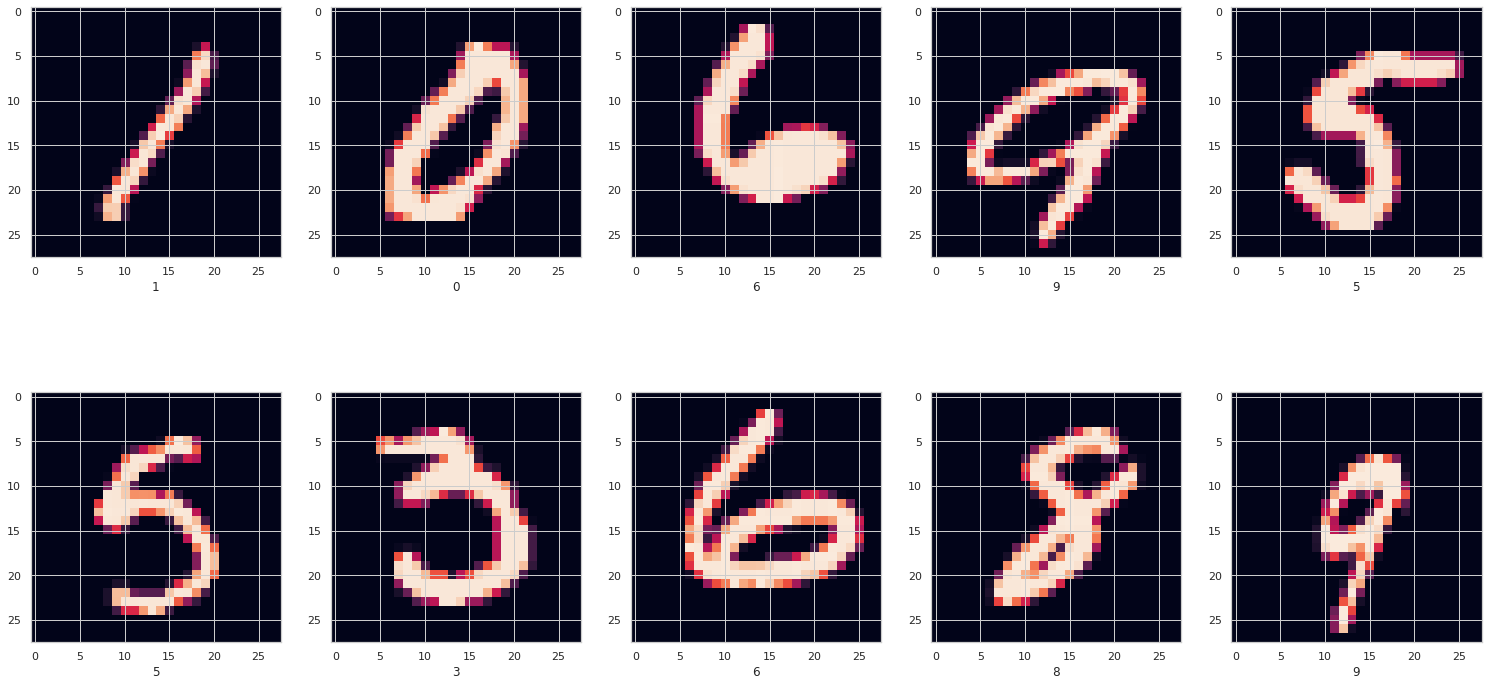

In [46]:
img_size = 28
fig = plt.figure(figsize=(26,13))
columns = 5
rows = 2

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digits))
    plt.imshow(digits[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))
plt.show()

KeyError: (slice(None, None, None), 0)

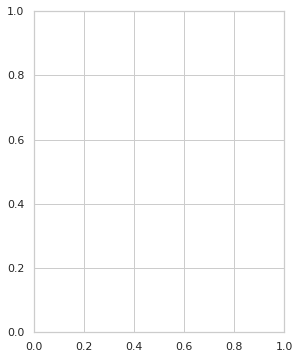

In [60]:
print_one_from_each(digits, 28)

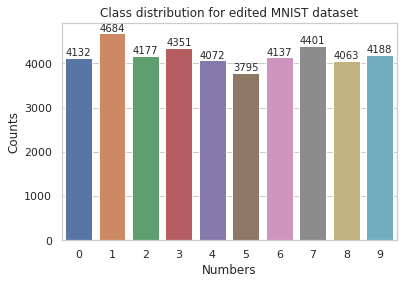

In [6]:
unique, counts = np.unique(labels, return_counts=True)
ax = sns.barplot(x=unique,y=counts)
ax.bar_label(ax.containers[0])
plt.title("Class distribution for edited MNIST dataset")
plt.ylabel("Counts")
plt.xlabel("Numbers")
plt.show()

In [7]:
digitsResized = np.zeros((len(digits), 14*14))

for i, d in enumerate(digits):
    _d = np.reshape(d, (28, 28)).astype('float32')
    resized_d = cv2.resize(_d, (14, 14))
    d_ = np.reshape(resized_d, (1, 14*14))
    digitsResized[i] = d_

# print('Digits resized', np.shape(digitsResized))

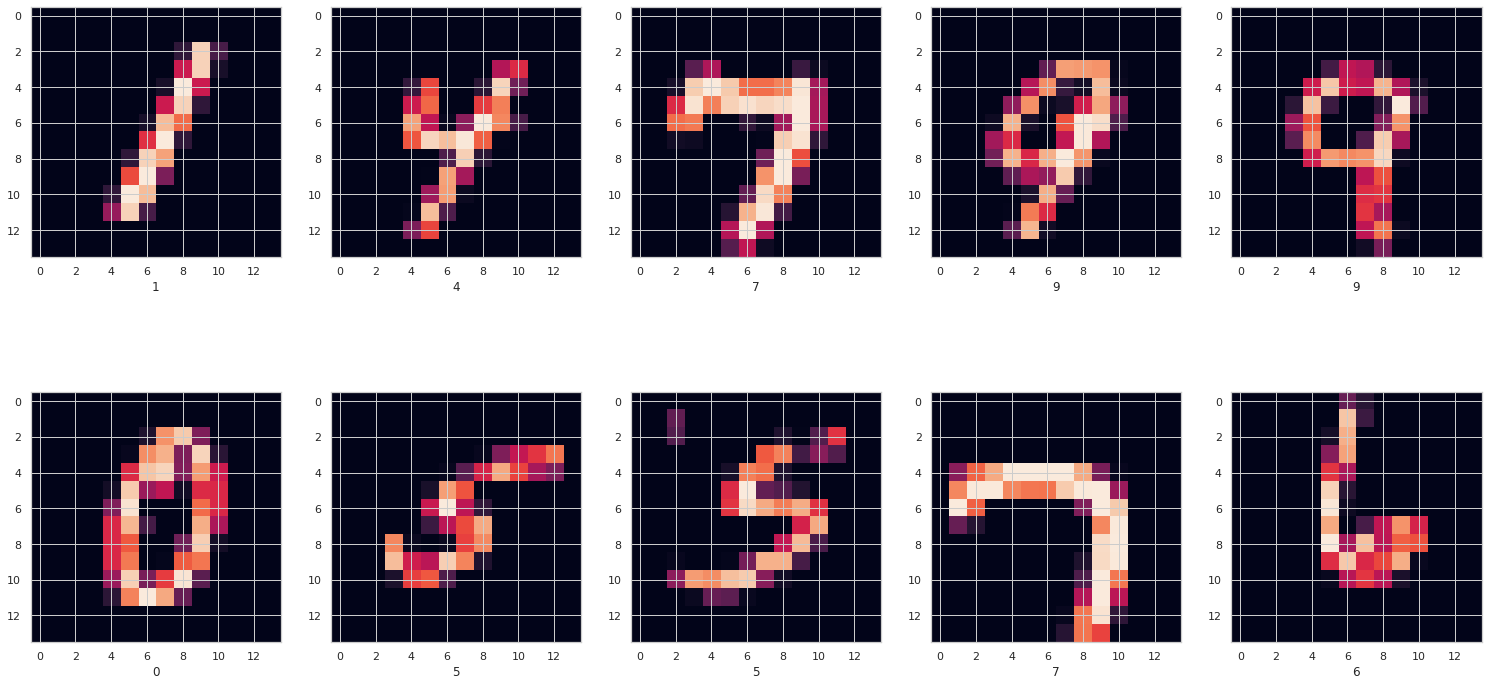

In [8]:
# Visually sampling the data

img_size = 14
columns = 5
rows = 2
fig = plt.figure(figsize=(26,13))

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    random_index = random.randrange(0, len(digitsResized))
    plt.imshow(digitsResized[random_index].reshape(img_size, img_size))
    plt.xlabel(str(labels[random_index]))

plt.show()

#### Drop useless features

Useless features are those with constant values across all data points, hence cannot be used to distinguish between data.

In [9]:
def filterConstantFeature(matrix, idx):
    return False if np.var(matrix[:, idx]) == 0.0 else True


cols_digits = list(range(0, len(digits[0])))
usefulCols_digits = [filterConstantFeature(digits, i) for i in cols_digits]
digitsFiltered = digits[:, usefulCols_digits]

cols_digitsResized = list(range(0, len(digitsResized[0])))
usefulCols_digitsResized = [filterConstantFeature(digitsResized, i) for i in cols_digitsResized]
digitsResizedFiltered = digitsResized[:, usefulCols_digitsResized]     # DATA: digits -> resized to 14x14 -> dropped constant features.

# print(np.shape(digitsResized))
# print(np.shape(digitsResizedFiltered))

In [22]:
# given some restriction on later parts of the assignment, I've opted to train ALL
# models with said restrictions; those being 
# - only training on 5000 samples
# - testing on the remaining (37000) samples

# let's see how that works out!

# Part 1. INK Feature Models
- Model 1. (Zero mean and SD=1) Multinomial Logit -> Ink Feature
- Model 2. (Zero mean and SD=1) MN Logit -> Ink Feature + Our own special feature

In [19]:
def print_feature(feat, feat_mean, feat_std):
    print(f"{feat}\n{feat_mean}\n{feat_std}\n")
    print(f"{np.size(feat)}, {np.size(feat_mean)}, {np.size(feat_std)}")

In [20]:
# creating ink feature
ink = np.array([sum(row) for row in digits])
ink_mean = [np.mean(ink[labels == i]) for i in range(10)] # mean for each digit
ink_std = [np.std(ink[labels == i]) for i in range(10)] # std for each digit
print_feature(ink, ink_mean, ink_std)

[16649 44609 13425 ... 31504 26381 18178]
[34632.40755082285, 15188.466268146884, 29871.099353603066, 28320.188002757986, 24232.72249508841, 25835.920421607378, 27734.917331399563, 22931.244262667577, 30184.148412503077, 24553.75]
[8461.892043158483, 4409.461697281539, 7653.006198983366, 7574.104535679545, 6374.633457092554, 7526.602988920305, 7530.503187255003, 6168.3408781754315, 7777.396357381105, 6465.231330430596]

42000, 10, 10


In [12]:
# i didn't see much difference between scaled and non-scaled ink
scaled_ink = (ink - np.mean(ink)) / np.std(ink)
print(scaled_ink)

[-1.09834377  2.11949181 -1.46938461 ...  0.61127524  0.02168398
 -0.92237558]


In [13]:
# our new feature - whitespace between numbers
# not just the opposite of ink, but the whitespace between a digit's
# rows and columns; 0 has a LOT of whitespace, 1 doesn´t have that much
def get_whitespace_feature(digits):
    ws = np.zeros(len(digits))
    
    print(ws)
    return ws

In [21]:
ws = get_whitespace_feature(digits)
ws_mean = [np.mean(ink[labels == i]) for i in range(10)] # mean for each digit
ws_std = [np.std(ink[labels == i]) for i in range(10)] # sd for each digit
print_feature(ws, ws_mean, ws_std)

[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[34632.40755082285, 15188.466268146884, 29871.099353603066, 28320.188002757986, 24232.72249508841, 25835.920421607378, 27734.917331399563, 22931.244262667577, 30184.148412503077, 24553.75]
[8461.892043158483, 4409.461697281539, 7653.006198983366, 7574.104535679545, 6374.633457092554, 7526.602988920305, 7530.503187255003, 6168.3408781754315, 7777.396357381105, 6465.231330430596]

42000, 10, 10


In [15]:
# setting up pipeline to facilitate modelling
# and consolidate training and testing datasets
# https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X = ink.reshape(-1, 1) # reshaping since it's a single feature
y = labels
# I know the instructions mention we don´t need to do this now,
# but I´d rather keep all models (reasonably) consistent
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    test_size=0.30)

# this pipeline logic is so we don´t leak data from the test set into the training set
scaled_logit = make_pipeline(StandardScaler(), LogisticRegression())
scaled_logit.fit(X_train, y_train)  # apply scaling on training data
scaled_logit.score(X_test, y_test)
y_pred = scaled_logit.predict(X_test)

In [16]:
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_results(model_desc, y_test, y_pred):
    print(f"\nResults for {model_desc}\n")
    print(classification_report(y_test, y_pred, zero_division=0)) # hiding zero division warn
    cm = confusion_matrix(y_test, y_pred, labels=scaled_logit.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scaled_logit.classes_)
    disp.plot()
    plt.show()


Results for MN LOGIT - INK FEATURE

              precision    recall  f1-score   support

           0       0.24      0.59      0.34      1200
           1       0.43      0.82      0.57      1389
           2       0.15      0.06      0.08      1294
           3       0.13      0.24      0.17      1355
           4       0.00      0.00      0.00      1222
           5       0.00      0.00      0.00      1085
           6       0.00      0.00      0.00      1256
           7       0.15      0.33      0.21      1359
           8       0.05      0.00      0.00      1209
           9       0.14      0.12      0.13      1231

    accuracy                           0.23     12600
   macro avg       0.13      0.22      0.15     12600
weighted avg       0.14      0.23      0.16     12600



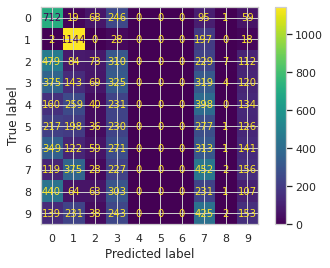

In [17]:
show_results("MN LOGIT - INK FEATURE", y_test, y_pred)

# Part 2. All Pixel Values Models
_**NOTE: Both with 784(14*14 pixels) features (all pixel values)**_

- Model 3. (Regularized?) MN Logit (w/ LASSO penalty) 
- Model 4. Support Vector Machines (SVM)

### MN Logit (w/ LASSO penalty)

In [18]:
# find a way to remove all pixels that always have constant value

logreg = sklearn.linear_model.LogisticRegression(penalty='l1', c=1,solver='saga')
# saga is the only solver that supports l1 penalty and multi-class problems
#arr = np.array([ink_mean, ink_std])
#print(pd.DataFrame(arr))
#print(df.loc[:, (df.sum() > 0).all()])

NameError: name 'sklearn' is not defined

### SVM + Grid Search -> All Pixel Values

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm import tqdm


# === Note on kernels and params ===

# rbf: gamma
# linear: x, x'
# sigmoid: coef0
# poly: degree, coef0
#   but coef0 can be safely left unchanged "in most cases" according to 
# https://stackoverflow.com/questions/21390570/scikit-learn-svc-coef0-parameter-range

paramGrid = {
    'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'C': [0.1, 0.5, 0.9, 1.5, 2, 2.5],
    'degree': [0.5, 1, 2, 5],
    'gamma': ['auto', 'scale'],
}

grid = GridSearchCV(SVC(), paramGrid, refit=True, verbose=3)
grid.fit(X_train2_std, y_train2)